# Lecture 33 - Slack Variables; Soft-Margin SVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

### Example of Hard-Margin SVM

Linearly-separable classes in the feature space spanned by the transformation $\phi(x)$ may form a non-linear decision boundary in the input space.

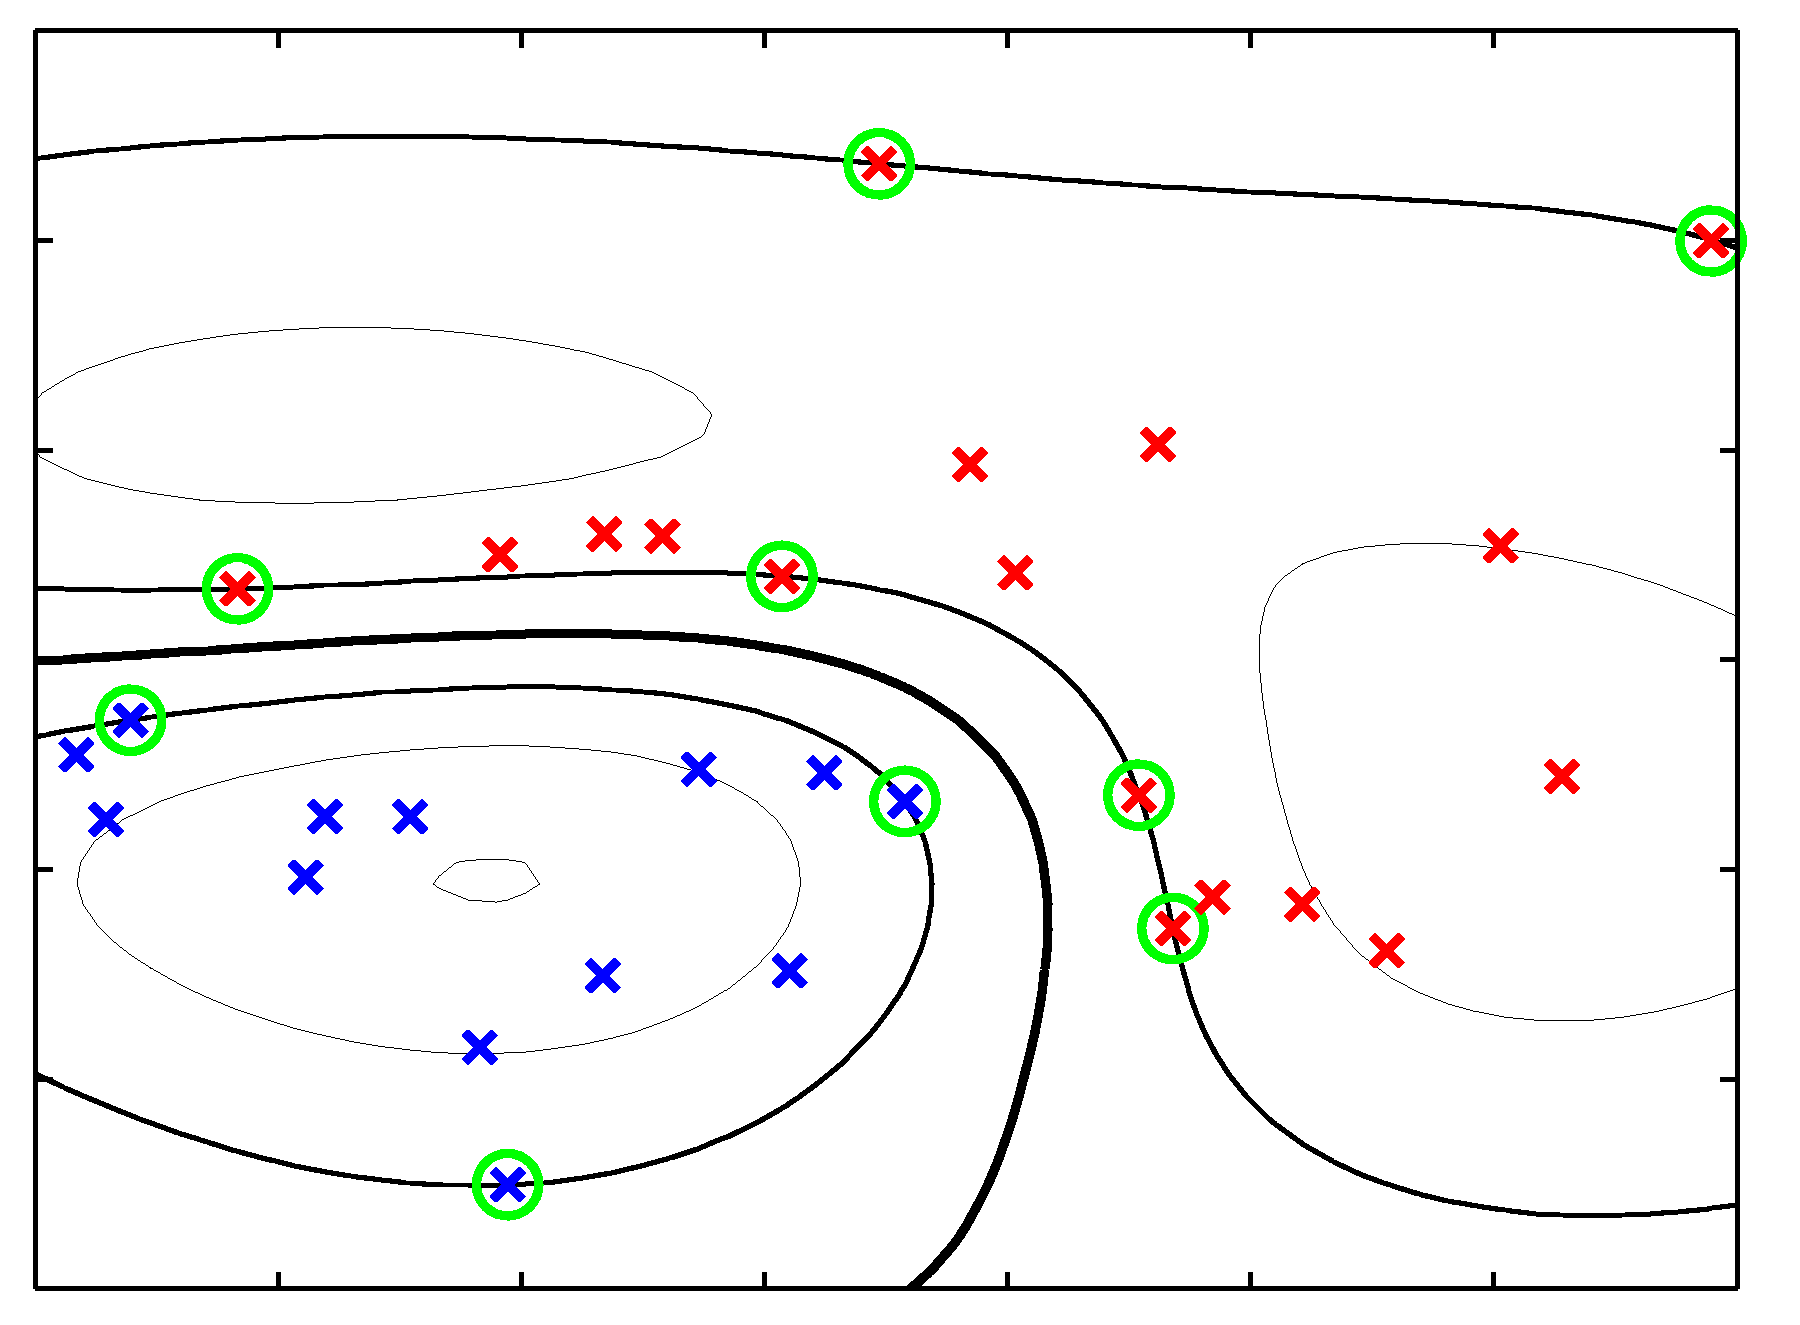

In [2]:
from IPython.display import Image
Image("figures/Figure7.2.png", width=400)

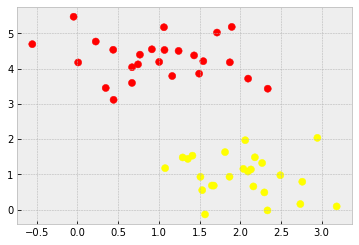

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

In [4]:
from sklearn.svm import SVC # "Support vector classifier"

model = SVC(kernel='linear')
model.fit(X, y)

SVC(kernel='linear')

In [5]:
# Python Data Science Handbook

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

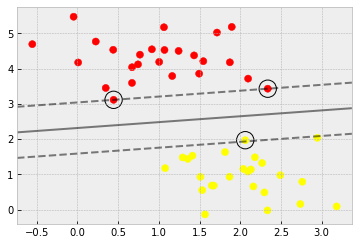

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [7]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

In [8]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 30, 60, 100, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 30, 60, 100, 200), value=10), Output()), _dom_cla…

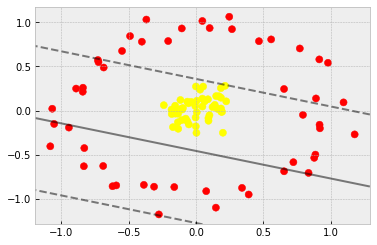

In [9]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

In [10]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

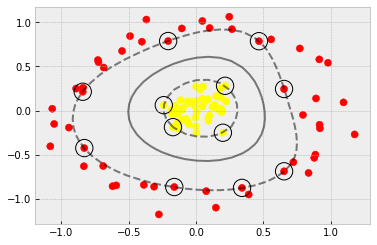

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

___

# Soft-Margin Support Vector Machine (SVM): Overlapping Classes

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as **slack varible** $\xi_n \geq 0$, $n=1,\dots, N$, with one slack variable for each training data point. For very large $\xi$, the margin is hard, and points cannot lie in it. For smaller $\xi$, the margin is softer, and can grow to encompass some points.

A **slack variable** is defined as $\xi_n = 0$ for data points that are on or inside the correct margin boundary and $\xi_n = |t_n - y(x_n)|$ for other points. Thus a data point that is on the decision boundary $y(x_n) = 0$ will have $\xi_n = 1$, and points with $\xi_n > 1$ will be misclassified. The exact classification constraints are then replaced with

$$t_n y(x_n) \geq 1 - \xi_n, n = 1, \dots, N$$

in which the slack variables are constrained to satisfy $\xi_n \geq 0$. 

* Data points for which $\xi_n = 0$ are correctly classified and are either on the margin or on the correct side of the margin. 
* Points for which $0 < \xi_n \leq 1$ lie inside the margin, but on the correct side of the decision boundary.
* And those data points for which $\xi_n > 1$ lie on the wrong side of the decision boundary and are misclassified.


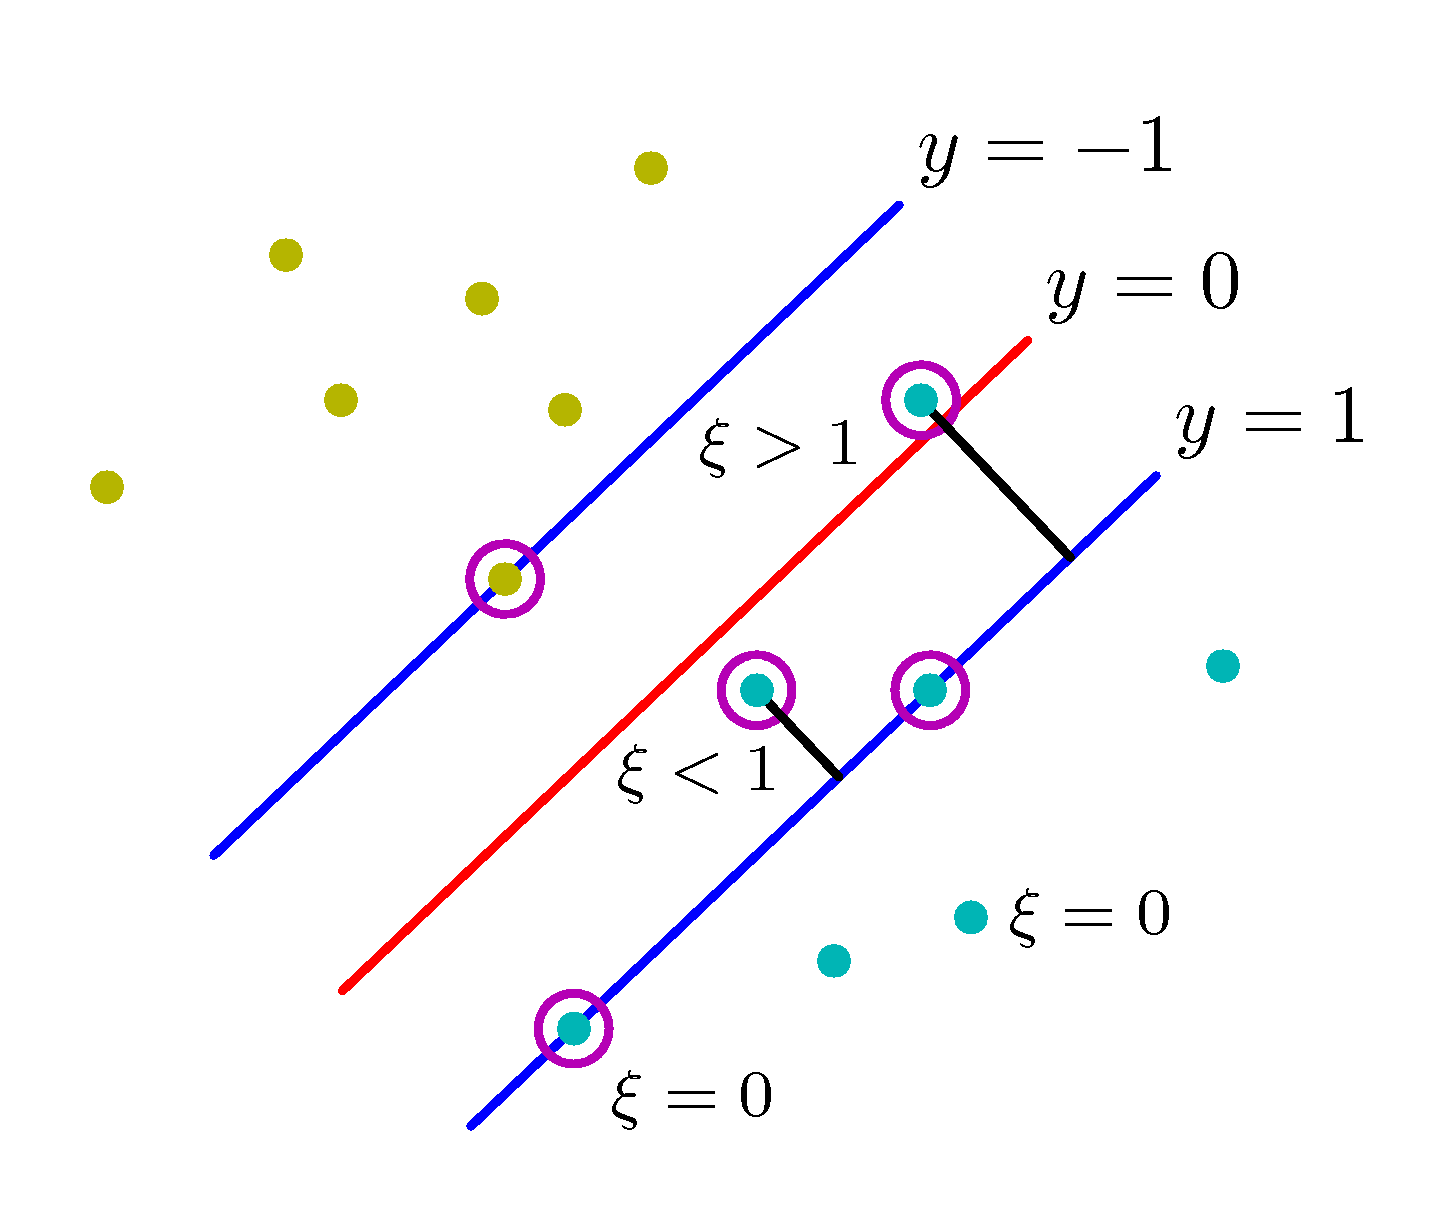

In [12]:
Image('figures/Figure7.3.png', width=400)

Our goal is now to maximize the margin while softly penalizing points that lie on the wrong side of the margin boundary. We therefore minimize:

\begin{align*}
&\arg_{w,b} \min C\sum_{n=1}^N \xi_n + \frac{1}{2} \Vert w\Vert^2 \\
\text{subject to    } &t_n y(x_n) \geq 1 - \xi_n, n = 1, \dots, N\\
\text{and    } &\xi_n \geq 0, n = 1, \dots, N
\end{align*}

where the parameter $C>0$ controls the trade-off between the slack variable penalty and the margin.

* Because any point that is misclassified has $\xi_n >1$, it follows that $\sum_n \xi_n$ is an upper bound on the number of misclassified points. 
* The parameter $C$ is therefore analogous to (the inverse of) a regularization coefficient because it controls the trade-off between minimizing training errors and controlling model complexity.
* In the limit $C \rightarrow \infty$, we will recover the earlier support vector machine for separable data.

The Lagrangian is given by:

\begin{align*}
L(w,b,a) = \frac{1}{2} \Vert w\Vert^2 + C\sum_{n=1}^N \xi_n - \sum_{n=1}^N a_n \left(t_n y(x_n) - 1 + \xi_n\right) - \sum_{n=1}^N \mu_n\xi_n
\end{align*}

where $\{a_n \geq 0\}_{n=1}^N$ and $\{\mu_n \geq 0\}_{n=1}^N$ are Lagrange multipliers. The corresponding set of 
Karush–Kuhn–Tucker (KKT) conditions are given by

\begin{align*}
a_n & \geq 0 \\
t_n y(x_n) - 1 + \xi_n & \geq 0 \\
a_n(t_n y(x_n) - 1 + \xi_n) & \geq 0 \\
\mu_n & \geq 0 \\
\xi_n & \geq 0\\
\mu_n \xi_n & = 0
\end{align*}

where $n = 1, \dots, N$.

We now optimize for $w$, $b$ and $\{\xi_n\}$:

\begin{align*}
\frac{\partial L}{\partial w} = 0 \Rightarrow & w = \sum_{n=1}^N a_n t_n \phi(x_n) \\
\frac{\partial L}{\partial b} = 0 \Rightarrow & \sum_{n=1}^N a_n t_n = 0 \\
\frac{\partial L}{\partial \xi_n} = 0 \Rightarrow & a_n = C - \mu_n \Rightarrow a_n \leq C
\end{align*}

The dual Lagrangian is then given by:

\begin{align*}
\tilde{L}(a) = \sum_{n=1}^N a_n - \sum_{n=1}^N\sum_{m=1}^N a_n a_m t_n t_m k(x_n, x_m)
\end{align*}

which is identical to the separable case, except that the constraints are somewhat different. We therefore have to minimize $\tilde{L}(a)$ with respect to the dual variables $\{a_n\}$ subject to

\begin{align*}
0 \leq a_n \leq C
\end{align*}

\begin{align*}
\sum_{n=1}^N a_n t_n = 0
\end{align*}

As before, a subset of the data points may have $a_n = 0$, in which case they do not contribute to the predictive model. The remaining data points constitute the support vectors. These have $a_n > 0$ and hence $t_n y(x_n) = 1 - \xi_n$.

* If $a_n < C$, then $\mu_n > 0$, which requires $\xi_n = 0$ and hence such points lie on the margin. 

* Points with $a_n = C$ can lie inside the margin and can either be correctly classified if $\xi_n \leq 1$ or misclassified if $\xi_n >1$.

To determine the parameter $b$, we note that those support vectors for which $0 < a_n < C$ have $\xi_n = 0$ so that $t_n y(x_n) = 1$ and hence will satisfy

\begin{align*}
t_n \left(\sum_{m\in S} a_m t_m k(x_n, x_m) + b\right) = 1
\end{align*}

Again, a numerically stable solution is obtained by averaging to give

\begin{align*}
b = \frac{1}{N_M} \sum_{n\in M}\left(t_n - \sum_{m\in S} a_m t_m k(x_n, x_m)\right)
\end{align*}

where $M$ denotes the set of indices of data points having $0 < a_n < C$.

Although predictions for new inputs are made using only the support vectors, the training phase (i.e., the determination of the parameters $a$ and $b$) makes use of the whole data set, and so it is important to have **efficient algorithms for solving the quadratic programming problem**.

We first note that the objective function $\tilde{L}(a)$ is quadratic and so any local optimum will also be a **global
optimum** provided the constraints define a convex region (which they do as a consequence of being linear).